# Pneumothorax Segmentation on X-ray Images

Dr. Yu Sun (yu.sun@sydney.edu.au)

15/11/2021


This is the following the previous work on the Kaggle competition on pneumothorax segmentation. This document including training using GPU is performed on a cloud server on [PaperSpace](https://www.paperspace.com/).

# Load data

The data is ziped and uploaded to the server.

In [ ]:
# Unzip the images
!unzip imgs.zip

In [ ]:
!ls

README.md  kaggle_pheumothorax.ipynb   quick_start_beginner.ipynb     utils.py
imgs	   mask_functions.py	       stage_2_sample_submission.csv
imgs.zip   quick_start_advanced.ipynb  train-rle.csv


Data has been transferred and unzipped. Next, check the number of files.

In [ ]:
import skimage.io
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
from mask_functions import *
from utils import *

In [ ]:
# Read the meta info
info = pd.read_csv('train-rle.csv')

In [ ]:
# Check unique imageid numbers
uniq_img_id = info['ImageId'].unique().copy()
uniq_img_id.shape

(12047,)

In [ ]:
# Check final file number, should double
! ls imgs | wc -w

24094


This shows the number of files matches.

# Data partitioning

The data will be partitioned into three partitions: a training set (70%), a validation set (20%) and a test set (10%). The training and validation set will be for model training, and the test data provides an indication of how well the model performs at the end.

In [ ]:
# Get the index of training, validation and test
# Ratio: 0.7, 0.2, 0.1
np.random.seed(1234)
n = len(uniq_img_id)
np.random.shuffle(uniq_img_id)
inTrain = uniq_img_id[:int(n*0.7)]
inVal   = uniq_img_id[int(n*0.7):int(n*0.9)]
inTest  = uniq_img_id[int(n*0.9):]


In [ ]:
# Get the shapes
shapes = len(inTrain), len(inVal), len(inTest)
print('Training: %d, validation: %d, test: %d' % shapes)

Training: 8432, validation: 2410, test: 1205


In [ ]:
assert sum(shapes) == n

# Data augmentation

Here we will implement data augmentation by applying a small rotation. This is becasue other operation such as scaling and shearing may introduce unrealistic changes to the data, which is unlikely in real-world situations.

In [ ]:
import numpy as np
import tensorflow as tf
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
from tensorflow import keras
plt.style.use('ggplot')

In [ ]:
# Implement the functions to rotate images
def rotateBatch(x, y):
    '''Roate the whole batch.
    x, y: the img and cont for each batch
    '''
    rand = np.random.random()
    angle = rand * 8 - 4
    x_r = rotate(x, angle, 0) 
    y_r = rotate(y, angle, 0) 
    return (x_r, y_r)

def rotate(arr, angle, cval):
    '''Roate an image stack
    arr: the image
    angle: the angle to rotate
    cval: the default value to fill
    '''
    result = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        img = arr[i, :, :, 0]
        img_r = skimage.transform.rotate(img, angle, cval=cval, 
                                         preserve_range=True)
        result[i, :, :, 0] = img_r
    return result

## Define the data generator

In [ ]:
# Data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, 
                 input_img_paths, target_img_paths,
                 cache_dir, preprocessor=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.preprocessor = preprocessor
        self.cache_dir = cache_dir
        self.cache = []

        if not os.path.exists(self.cache_dir):
          os.makedirs(self.cache_dir)

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        cacheFile = path(self.cache_dir, f'{idx}.npz')
        if idx in self.cache:
            # print('Using cache')
            batch = np.load(cacheFile)
            x = batch['x']
            y = batch['y']
        else:
            i = idx * self.batch_size
            batch_input_img_paths = self.input_img_paths[i: i+self.batch_size]
            batch_target_img_paths = self.target_img_paths[i: i+self.batch_size]
            x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.float16)
            for j, _path in enumerate(batch_input_img_paths):
                # img = np.load(_path)
                img = skimage.io.imread(_path)
                img = skimage.transform.resize(img, self.img_size, 
                                                preserve_range=True)
                if self.preprocessor:
                  img = self.preprocessor(img)
                img = np.expand_dims(img, 2)
                x[j] = img
            y = np.zeros((self.batch_size,)+self.img_size+(1,), dtype=np.float16)
            for j, _path in enumerate(batch_target_img_paths):
                # img = np.load(_path)
                img = skimage.io.imread(_path)
                img = skimage.transform.resize(img, self.img_size, 
                                                preserve_range=True)
                img  = np.expand_dims(img, 2)
                img = img / 255.0
                y[j] = img            
            np.savez_compressed(cacheFile, x=x, y=y)
            self.cache.append(idx)
            # print('Cache saved')
        x, y = rotateBatch(x, y)
        x = np.repeat(x[:,:,:], 3, axis=3)
        y = (y>0.5)*1.0 # Remove the interpolated values
        return x, y

# Model architecture

Due to the nature of segmentation, a U-net is used for this task with transferred learning. Pre-trained weights will be helpful.

A good selection of segmentation models are available from the `segmentation_models` library, as the name suggests. It provides a simple interface to prototype exising networks in `keras` and you can select different pre-trained networks as backbones. Weights from image net is also available. Although natural images are quite different from medical images, the layers to detect layers, corners and blobs are consistently useful regardless of the image type.

Previously, there is no specific guideline on scaling a CNN. For more complicated tasks, one might increase the number of layers, while the others will add more filters. It's based on the designer's exprience. EfficientNet is a family of CNN that help the user to better scale up the model on the resolution (image size), depth (number of layers) and width (number of filters). For an input of 256 x 256, the EfficientNetB4 is chosen as it was trained using a similar input shape. It should serve as a suitable feature extractor for this task.

In [ ]:
! pip install segmentation_models

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [ ]:
backbone = 'efficientnetb4'

In [ ]:
preprocess_input = sm.get_preprocessing(backbone)

In [ ]:
model = sm.Unet(backbone, input_shape=(None, None, 3), 
                encoder_weights='imagenet')

2021-11-15 11:25:53.213651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:25:53.346461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:25:53.348177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:25:53.353651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 11:25:53.355296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

71901184/71892840 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
______________________________________________________________________________________________

# Instantiate data generators

The original image shape 1024 x 1024 will result in a high memory usage. After inspections on the data, it's suitable to resize the image to 256 x 256. This is selected as the image details are still present after downsize. A further downsize (128 x 128) will cause significant loss of details, which makes it hard for the model to predict.

With 256 x 256, a batch size of 16 is selected due to the limitation of Colab's memory. In practice, this can be around 64. A small batch size will takes longer for the training to converge.

In [ ]:
# Define the paths
dataDir = 'imgs'
fl = os.listdir(dataDir)

# Training file paths
train_img_paths = [path(dataDir, f+'-i.jpg') for f in inTrain]
train_cnt_paths = [path(dataDir, f+'-c.jpg') for f in inTrain]

# Validation
val_img_paths = [path(dataDir, f+'-i.jpg') for f in inVal]
val_cnt_paths = [path(dataDir, f+'-c.jpg') for f in inVal]

# Test
test_img_paths = [path(dataDir, f+'-i.jpg') for f in inTest]
test_cnt_paths = [path(dataDir, f+'-c.jpg') for f in inTest]

In [ ]:
batch_size = 32
img_size = (256, 256)

In [ ]:
# Remove the previous cache folders
# Do this only if you re-initiate the generator
! rm -rf _cache*

In [ ]:
# Generator
train_gen = DataGen(batch_size, img_size, 
                    train_img_paths, train_cnt_paths, 
                    '_cache_tr', preprocess_input)
val_gen = DataGen(batch_size, img_size, 
                    val_img_paths, val_cnt_paths, 
                    '_cache_vl', preprocess_input)

A quick sanity check on the shape and dtype of a batch.

In [ ]:
x, y = train_gen[0]

In [ ]:
x.shape

(32, 256, 256, 3)

In [ ]:
y.shape

(32, 256, 256, 1)

In [ ]:
x.dtype

dtype('float16')

In [ ]:
np.unique(y)

array([0., 1.])

The shape and dtype is correct.

# Training

In [ ]:
# Compile the model
# Adam is used here to utilise the training momentum
# A dice loss is used for measuring overlap
# IOU will be recorded which is consistant with the 
#  competition evaluation metrics

model.compile(
    optimizer='adam',
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score],
)

In [ ]:
keras.backend.clear_session()

In [ ]:
# Epoch and the directory to save data
epochs = 150
saveDir = './'

In [ ]:
# Define a callback to save the best model 
#  on the validation set
callbacks = [
    keras.callbacks.ModelCheckpoint(
        path(saveDir, "kaggle_pt_best.h5"), 
        save_best_only=True
    )
]

In [ ]:
# Train and save the history
# Data will be saved to the cloud over night
#  so that the browser can be disconnected during training
for e in range(epochs):
    print(f'Epoch {e}'.center(50, '-'))
    history = model.fit(train_gen, epochs=1, validation_data=val_gen, 
                            callbacks=callbacks)
    with open(path(saveDir, 'history', f'history-{e}.txt'), 'w') as f:
        f.write(str(history.history))
    # weights = model.get_weights()
    # np.save(path('weights', f'model-{e}.npy'), weights, allow_pickle=True)

The training went over night. Check the history files to make sure it has 150 epoch (`history-149.txt`).

In [ ]:
! ls history/history-14*

history/history-14.txt	 history/history-143.txt  history/history-147.txt
history/history-140.txt  history/history-144.txt  history/history-148.txt
history/history-141.txt  history/history-145.txt  history/history-149.txt
history/history-142.txt  history/history-146.txt


Extrac the training metrics.

In [ ]:
# Collect the metrics into a list
hists = []
for e in range(epochs):
    histFile = path('history', f'history-{e}.txt')
    with open(histFile) as f:
        hist = {'epoch': e}
        hist.update(eval(f.read()))
        hists.append(hist)

In [ ]:
# Convert the list to a data frame
histPd = pd.concat([pd.DataFrame(h) for h in hists])
histPd.reset_index(drop=True, inplace=True)
histPd

,epoch,loss,iou_score,val_loss,val_iou_score
0,0,0.693177,0.191919,0.729304,0.162168
1,1,0.661650,0.215386,0.671970,0.207332
2,2,0.700351,0.186548,0.702161,0.189994
3,3,0.624943,0.243141,0.647668,0.229605
4,4,0.589158,0.272196,0.628669,0.239003
...,...,...,...,...,...
145,145,0.207740,0.667978,0.617756,0.256233
146,146,0.206763,0.669212,0.611315,0.257811
147,147,0.205325,0.671536,0.622400,0.251058
148,148,0.222254,0.648753,0.635877,0.242235


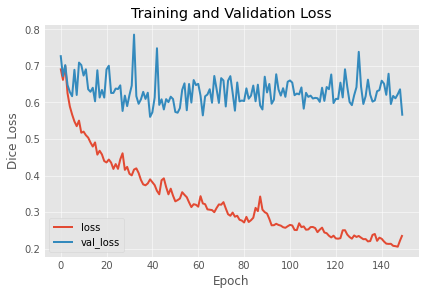

In [ ]:
# Loss
histPd.plot(x='epoch', y=['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Loss')
plt.show()

From the plot one can tell
* The training and validation loss are decreasing. This means the gradient descent is working.
* The validation loss decreased from epoch 0 to 20, then saturated around 0.6 from epoch 40 onwards, while the training data keeps decreasing. This means over-fitting occured around epoch 30, after which the model learns the details only present in training data, but can be generalised.
* The gap between the training and validation is quite big, which suggests more data is required. Typically when data are added, the training loss will increase (more variations to deal with) and the validation loss will decrease (more generalisable patten learnt).
* Since the validation loss fluctuated around 0.6, with no addition benefit onwards, the training can stop around epoch 30 to reduce the adverse effect from overfitting.

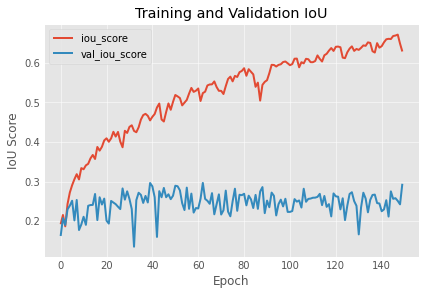

In [ ]:
# Loss
histPd.plot(x='epoch', y=['iou_score', 'val_iou_score'])
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.title('Training and Validation IoU')
plt.show()

The IoU score generally mirrors the loss.
* Training score keep rising: more details are learnt by the model from the training data.
* Validation score plateaued between epoch 30 and 60, with a minor peak around epoch 60.
* This marks the limit of information can be learnt by the model with the current data setting.
* Further training beyond epoch 60 will add to the risk of over-fitting. In this plot, the validation score didn't deteriote significantly after epoch 60, but one can predict the general trend will be a decrease.

Take a look at the maximum validation IoU score. This is the best model saved by the callback, which will be applied on the test data.

In [ ]:
histPd[histPd['val_iou_score']==histPd['val_iou_score'].max()]

,epoch,loss,iou_score,val_loss,val_iou_score
62,62,0.323647,0.523606,0.56458,0.296458


# On the test data

Get the best model and apply it on the test data from the data partitioning.

In [ ]:
# Load the best model
model_best = keras.models.load_model(
    path(saveDir, "kaggle_pt_best.h5"),
    custom_objects={
        'dice_loss': sm.losses.dice_loss,
        'iou_score': sm.metrics.iou_score
    }
)

In [ ]:
# Initiate the test data generator
test_gen = DataGen(batch_size, img_size, 
                    test_img_paths, test_cnt_paths, 
                    '_cache_test', preprocess_input)

In [ ]:
# Evaluate the performance
perf = model_best.evaluate(test_gen)

37/37 [==============================] - 12s 315ms/step - loss: 0.5950 - iou_score: 0.2762


This matches with the training statistics that a comparable but slightly lower score is achieved on the test data. Next the model will be applied on the submission data.

# Submission

The submission data `siim-acr-pneumothorax-segmentation.zip` is uploaded to the server as `submission-data.zip`. First, unzip it.

In [ ]:
! unzip submission-data.zip -d submission-data

## Prepare the submission

In [ ]:
# Read the submission template
sub = pd.read_csv('stage_2_sample_submission.csv')

In [ ]:
# Folder that contains the DICOM
dataDir = path('submission-data', 'stage_2_images')

In [ ]:
# Iterate through the images and make the prediction
#
# Main steps
#  Get the image arrays as input
#  Pre-process the input as per the training process
#  Apply the best model on the input
#  Convert the output to rle format
#  Save the rle

preds = []

for imageid in tqdm(sub['ImageId']):
     
    # Read DICOM
    dcmPath = path(dataDir, imageid+'.dcm')
    dcm = pydicom.read_file(dcmPath)
    img = dcm.pixel_array
    img_shape = img.shape
    assert img_shape == (1024, 1024)
    
    # Preprocess the input as per the training
    img = skimage.transform.resize(img, (256, 256), preserve_range=True)
    img = preprocess_input(img)
    img = img.reshape((1,)+img.shape+(1,))
    img = np.repeat(img[:,:,:], 3, axis=3)
    # print(img.shape)
    
    # Make prediction
    pred = model.predict(img).reshape((256, 256))
    pred = skimage.transform.resize(pred, img_shape, preserve_range=True)
    mask = (pred > 0.5) * 1.0
    mask = mask.T.astype(np.uint8)*255
    
    # Convert to run length encoding
    rle = mask2rle(mask, *img_shape)
    preds.append(rle)
  

100%|██████████| 3205/3205 [35:46<00:00,  1.49it/s]


In [ ]:
sub['EncodedPixels'] = preds

In [ ]:
sub.head()

,ImageId,EncodedPixels
0,ID_c68e114ba,
1,ID_b5a797789,
2,ID_490a04f54,
3,ID_823ca20e1,323701 6 1017 8 1016 8 1015 9 1013 11 1012 12 ...
4,ID_5face2763,


In [ ]:
sub.to_csv('submission.csv', index=False)

## Score

The prediction has been successfully submitted. The public score is 0.8572.



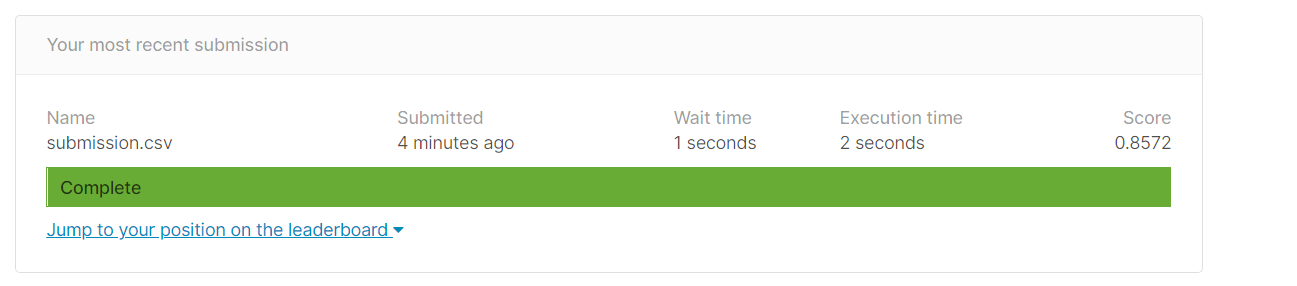

# Final remarks

## About the submission score
* The submission score is 0.8572.
* The score is actually higher than I expected given the relative low IoU score for each instance. 
* This can be due to that a large portion of the cases are pneumothorax free. Hence if the model can distinguish the presence of pneumothorax, it wil have a reasonable performance.

## Limitations of the current model
* The current model is a basic u-net with pre-trained weights from image net. 
    * It's model without attention mechanisms. 
    * Given the small percentage of the contour coverage, it is quite inefficient for the network to search for global features, as most of the pneumothorax are around the lung borders.
    * A model with attention mechanism will definite help.
* During training, a small batch size is used due to the limited GPU memory. Increasing the batch size to 64 or 128 will improve the training converge. However, this may only speed up the training but not change the performance. 
* A downsized input is used due to limited resources, which loses some of the fine details, particularly the textures of the lungs.

## Future work
* A model with attention can be tested.
* Two stage approaches can be consider
    * The first stage isolated the suspicious regions, mostly the borders of the lungs, using region proposal.
    * The second stage will look at the details 
    * This is similar to Mask R-CNN, which does this in one network.
* Use the original image resolution rather than a downsized one.
* Use pre-trained weights from medical images rather than natural images.
* Increase the batch size during training.
* Diversify the operations in data augmentation.
* Include feature maps such as edges in the input, as the pneumothorax is between the border of the lung and thorax.

-------

In [ ]:
# Print the session information for reproducibility purposes
import IPython
print(IPython.sys_info())
print(f'{keras.__version__=}')
print(f'{tf.__version__=}')

{'commit_hash': '24512bd29',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/usr/local/lib/python3.8/dist-packages/IPython',
 'ipython_version': '7.27.0',
 'os_name': 'posix',
 'platform': 'Linux-5.4.0-65-generic-x86_64-with-glibc2.29',
 'sys_executable': '/usr/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.10 (default, Jun  2 2021, 10:49:15) \n[GCC 9.4.0]'}
keras.__version__='2.6.0'
tf.__version__='2.6.0'


This is the end of the document.